# Finalise model predictors

Weight the data by population and by state, then detrend.

In [1]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

import bottleneck

In [29]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "03:30:00"
cores = 12
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                                          
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40329 instead
  warnings.warn(


In [30]:
cluster.scale(jobs=1)
client = Client(cluster)

In [65]:
client

<Client: 'tcp://10.6.121.1:39821' processes=12 threads=12, memory=44.76 GiB>

In [2]:
import xarray as xr
import pandas as pd

In [3]:
%cd /g/data/w42/dr6273/work/demand_model//

import functions as fn

/g/data/w42/dr6273/work/demand_model


# Load population and region mask

In [4]:
nem_pop = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_population_density_state_mask.nc"
)["population_density"]

In [5]:
nem_pop_discrete_10 = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_population_density_state_mask_discrete_10.nc"
)["population_bins_10"]

nem_pop_discrete_100 = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_population_density_state_mask_discrete_100.nc"
)["population_bins_100"]

nem_pop_discrete_1000 = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_population_density_state_mask_discrete_1000.nc"
)["population_bins_1000"]

nem_pop_log = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_population_density_state_mask_log.nc"
)["log_population_density"]

In [6]:
eu_pop = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/EU_population_count_mask.nc"
)["population_count"]

Prepare masks

In [7]:
def scale(da):
    """
    Scale da to be between 0 and 1.
    """
    return (da - da.min()) / (da.max() - da.min())

In [8]:
def prepare_mask(mask):
    """
    Scale mask to be 0-1, set NaNs to zero and chunk.
    """
    mask = mask.where(mask.notnull(), 0)
    return scale(mask).chunk()

In [9]:
nem_pop = prepare_mask(nem_pop)
nem_pop_discrete_10 = prepare_mask(nem_pop_discrete_10)
nem_pop_discrete_100 = prepare_mask(nem_pop_discrete_100)
nem_pop_discrete_1000 = prepare_mask(nem_pop_discrete_1000)
nem_pop_log = prepare_mask(nem_pop_log)
eu_pop = prepare_mask(eu_pop)

And a non-weighted mask

In [10]:
equal_mask = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_state_mask.nc"
)["mask"]

# Weight predictors and average over regions

We open the data differently depending on whether we need derived indices, which are available as zarr stores, or basic daily ERA5 data, which are separate netcdf files for each year.

In [14]:
def sel_NEM(ds, lat_name="lat", lon_name="lon"):
    """
    Select NEM region. Renames coords to lat/lon if not already.
    
    ds: dataset or array to sel on.
    lat_name, lon_name: names of lat/lon coords.
    """
    if lat_name != "lat":
        ds = ds.rename({lat_name: "lat"})
    if lon_name != "lon":
        ds = ds.rename({lon_name: "lon"})
        
    return ds.sel(lon=slice(125, 155), lat=slice(-10, -45))

In [15]:
def sel_EU(ds, lat_name="lat", lon_name="lon"):
    """
    Select Europe region. Renames coords to lat/lon if not already.
    
    ds: dataset or array to sel on.
    lat_name, lon_name: names of lat/lon coords.
    """
    if lat_name != "lat":
        ds = ds.rename({lat_name: "lat"})
    if lon_name != "lon":
        ds = ds.rename({lon_name: "lon"})
        
    return ds.sel(lon=slice(-12, 30), lat=slice(75, 35))

In [16]:
def read_zarr(fp):
    """
    Open zarr collection of ERA5 data.
    
    fp: str, path to file.
    """
    return xr.open_zarr(fp, consolidated=False)

In [81]:
def zarr_read_and_sel(fp, lat_slice, lon_slice, lat_name="lat", lon_name="lon"):
    """
    Open zarr store, select region and rename lat/lon.
    
    fp: str, path to file.
    lat_slice, lon_slice: slice of lat/lon to subset
    lat_name, lon_name: names of lat/lon coords.
    """
    ds = read_zarr(fp)
    ds = ds.rename({lat_name: "lat", lon_name: "lon"})
    return ds.sel(lon=lon_slice, lat=lat_slice)

In [75]:
def open_daily(fp, lat_slice, lon_slice, lat_name="lat", lon_name="lon"):
    """
    Open multiple daily ERA5 files and preprocess to region.
    
    fp: str, path to file. Should not include files, only the path to dir.
    lat_slice, lon_slice: slice of lat/lon to subset
    lat_name, lon_name: names of lat/lon coords.
    """
    def preprocess(ds):
        ds = ds.rename({lat_name: "lat"})
        ds = ds.rename({lon_name: "lon"})
        return ds.sel(lon=lon_slice, lat=lat_slice)
    
    ds = xr.open_mfdataset(
        fp,
        preprocess=preprocess,
        chunks={"time": "200MB"}
    )
    return ds

In [76]:
def read_data(fp, lat_slice, lon_slice, lat_name="lat", lon_name="lon"):
    """
    Reads and processes data to NEM region according to whether
    the data are stored as zarr or multiple netcdf files.
    
    fp: str, path to file.
    lat_name, lon_name: names of lat/lon coords.
    """
    if fp[-5:] == ".zarr":
        return zarr_read_and_sel(fp, lat_slice=lat_slice, lon_slice=lon_slice, lat_name=lat_name, lon_name=lon_name)
    elif fp[-3:] == ".nc":
        return open_daily(fp, lat_slice=lat_slice, lon_slice=lon_slice, lat_name=lat_name, lon_name=lon_name)
    else:
        raise ValueError("Unrecognised file type.")

In [20]:
def population_mean(ds, mask):
    """
    Compute the spatial average of population-weighted data for each region.
    
    ds: dataset or array to process
    mask: population mask/data
    """
    return ds.weighted(mask).mean(["lat", "lon"])

In [21]:
def detrend_ds(ds, var_name, new_var_name, dim="time"):
    """
    Detrend a dataset, retaining the mean, and rename variable.
    
    ds: dataset to detrend
    var_name: name of variable to detrend
    new_var_name: new name of detrended variable
    dim: dimension along which to detrend
    """
    mu = ds[var_name].mean(dim)
    dt = fn.detrend_dim(ds[var_name], dim)
    return (mu + dt).to_dataset(name=new_var_name)

In [22]:
def write(ds, fp):
    """
    Write to file and chunk to single chunk.
    
    ds: dataset to write.
    fp: str, path to write to.
    """
    ds = ds.chunk({"time": -1})
    # ds.to_zarr(fp, mode="w", consolidated=True)
    ds.to_netcdf(fp + ".nc")

Dictionary of variables to process.

Organised with the variable name as the key, then a list as follows:
`[path_to_open, lat_name, lon_name, path_to_write, var_name, new_var_name]`

In [25]:
era_path = "/g/data/w42/dr6273/work/data/era5/"

In [26]:
write_path = "/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/"

In [82]:
variables = {
    # "msdwswrf": [
    #     era_path + "msdwswrf/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "msdwswrf_era5_daily_1959-2022_NEM",
    #     "msdwswrf",
    #     "msdwswrf"
    # ],
    # "10w": [
    #     era_path + "10w/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "10w_era5_daily_1959-2022_NEM",
    #     "w10",
    #     "w10"
    # ],
    # "2t": [
    #     era_path + "2t/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "2t_era5_daily_1959-2022_NEM",
    #     "t2m",
    #     "t2m"
    # ],
    # "2tmax": [
    #     era_path + "2tmax/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "2tmax_era5_daily_1959-2022_NEM",
    #     "mx2t",
    #     "t2max"
    # ],
    # "2tmin": [
    #     era_path + "2tmin/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "2tmin_era5_daily_1959-2022_NEM",
    #     "mn2t",
    #     "t2min"
    # ],
    # "mtpr": [
    #     era_path + "mtpr/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "mtpr_era5_daily_1959-2022_NEM",
    #     "mtpr",
    #     "mtpr"
    # ],
    # "rh": [
    #     era_path + "rh/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "rh_era5_daily_1959-2022_NEM",
    #     "rh",
    #     "rh"
    # ],
    # "q": [
    #     era_path + "q/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "q_era5_daily_1959-2022_NEM",
    #     "q",
    #     "q"
    # ],
    # "cdd": [
    #     era_path + "derived/cdd_24_era5_daily_1959-2022.zarr",
    #     "latitude",
    #     "longitude",
    #     write_path + "cdd_24_era5_daily_1959-2022_NEM",
    #     "cdd",
    #     "cdd"
    # ],
    # "hdd": [
    #     era_path + "derived/hdd_18_era5_daily_1959-2022.zarr",
    #     "latitude",
    #     "longitude",
    #     write_path + "hdd_18_era5_daily_1959-2022_NEM",
    #     "hdd",
    #     "hdd"
    # ],
    "cdd3": [
        era_path + "derived/cdd_24_Aus_rollmean3_era5_daily_1959-2022.zarr",
        "latitude",
        "longitude",
        write_path + "cdd_24_rollmean3_era5_daily_1959-2022_NEM",
        "cdd",
        "cdd3"
    ],
    "cdd4": [
        era_path + "derived/cdd_24_Aus_rollmean4_era5_daily_1959-2022.zarr",
        "latitude",
        "longitude",
        write_path + "cdd_24_rollmean4_era5_daily_1959-2022_NEM",
        "cdd",
        "cdd4"
    ],
    "hdd3": [
        era_path + "derived/hdd_18_Aus_rollmean3_era5_daily_1959-2022.zarr",
        "latitude",
        "longitude",
        write_path + "hdd_18_rollmean3_era5_daily_1959-2022_NEM",
        "hdd",
        "hdd3"
    ],
    "hdd4": [
        era_path + "derived/hdd_18_Aus_rollmean4_era5_daily_1959-2022.zarr",
        "latitude",
        "longitude",
        write_path + "hdd_18_rollmean4_era5_daily_1959-2022_NEM",
        "hdd",
        "hdd4"
    ],
    "2t3": [
        era_path + "derived/2t_Aus_rollmean3_era5_daily_1959-2022.zarr",
        "latitude",
        "longitude",
        write_path + "2t_rollmean3_era5_daily_1959-2022_NEM",
        "t2m",
        "t2m3"
    ],
    "2t4": [
        era_path + "derived/2t_Aus_rollmean4_era5_daily_1959-2022.zarr",
        "latitude",
        "longitude",
        write_path + "2t_rollmean4_era5_daily_1959-2022_NEM",
        "t2m",
        "t2m4"
    ]
}

Loop through and process

In [83]:
for key, values in zip(variables.keys(), variables.values()):
    _ds = read_data(values[0], slice(-10, -45), slice(125, 155), values[1], values[2])
    for mask, mask_name in zip(
        [equal_mask, nem_pop, nem_pop_discrete_10, nem_pop_discrete_100, nem_pop_discrete_1000, nem_pop_log],
        ["no_mask", "pop_dens_mask", "pop_discrete_10_mask", "pop_discrete_100_mask", "pop_discrete_1000_mask", "pop_dens_log_mask"]
    ):
    # for mask, mask_name in zip([equal_mask], ["no_mask"]):
        ds = population_mean(_ds, mask)
        ds = detrend_ds(ds, values[4], values[5])
        fp = values[3] + "_" + mask_name
        write(ds, fp)

KeyError: 'cdd'

In [89]:
values

['/g/data/w42/dr6273/work/data/era5/derived/cdd_24_Aus_rollmean3_era5_daily_1959-2022.zarr',
 'latitude',
 'longitude',
 '/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/cdd_24_rollmean3_era5_daily_1959-2022_NEM',
 'cdd',
 'cdd3']

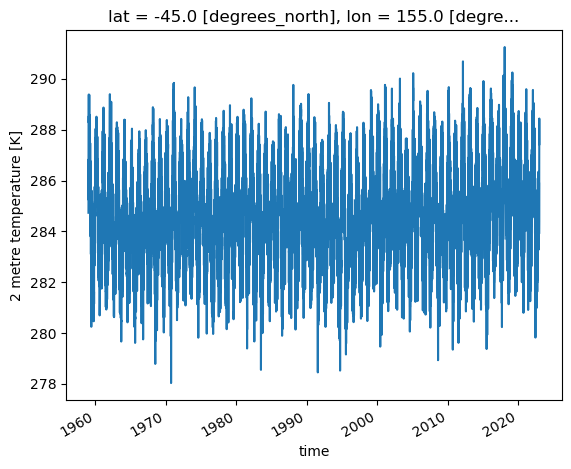

In [86]:
_ds.t2m.isel(lat=-1, lon=-1).plot()

In [96]:
x = xr.open_zarr("/g/data/w42/dr6273/work/data/era5/derived/cdd_24_Aus_rollmean3_era5_daily_1959-2022.zarr/")

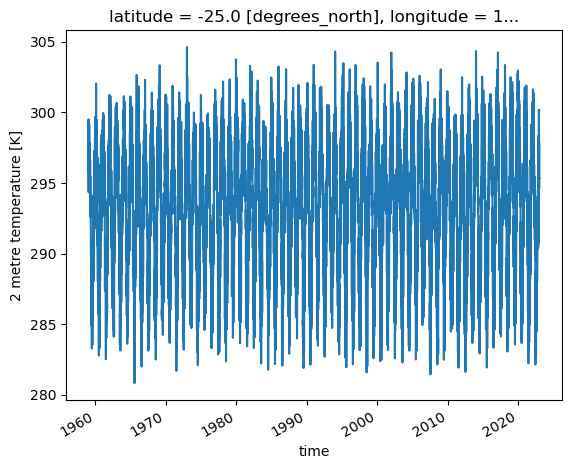

In [98]:
x.t2m.sel(latitude=-25, longitude=151).plot()

Now for Europe

In [87]:
variables = {
    "2t": [
        era_path + "2t/daily/*.nc",
        "latitude",
        "longitude",
        write_path + "2t_era5_daily_1959-2022_EU",
        "t2m",
        "t2m"
    ]
}

In [90]:
for key, values in zip(variables.keys(), variables.values()):
    ds = read_data(values[0], slice(75, 35), slice(-12, 30), values[1], values[2])
    ds = population_mean(ds, eu_pop)
    ds = detrend_ds(ds, values[4], values[5])
    fp = values[3] + "_pop_dens_mask"
    write(ds, fp)

# Close cluster

In [32]:
client.close()
cluster.close()